In [1]:
!pip install openai==0.28

In [2]:
import json

# Load the JSON data from a file
with open('/content/filtered_politeness.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

In [3]:
import openai
import os
import time


openai.api_key = 'sk-zdV6D5FqM-TU2j_PPQsJzA'

openai.api_base = 'https://cmu.litellm.ai'

def rate_politeness(question):
    prompt = f"""Please rate the politeness of the following question on a scale from 1 to 5, where:
1 = Very impolite
2 = Impolite
3 = Neutral
4 = Polite
5 = Very polite

Only provide the number without any additional text.

Question: "{question}"\n\nRating:"""
    try:
        response = openai.Completion.create(
            engine="gpt-4o-mini",
            prompt=prompt,
            max_tokens=1,
            temperature=0,
            n=1,
            stop=None,
        )
        rating = response.choices[0].text.strip()
        if rating in ['1', '2', '3', '4', '5']:
            return int(rating)
        else:
            return None
    except Exception as e:
        print(f"Error rating question: {e}")
        return None


In [4]:
# Create a list to store the results
results = []

# Iterate over each item in the data
for item in data:
    question = item['question']
    polite_question = item.get('polite_question', '')
    impolite_question = item.get('impolite_question', '')

    # Rate the original question
    original_rating = rate_politeness(question)
    time.sleep(1)  # To respect API rate limits

    # Rate the polite question if available
    if polite_question:
        polite_rating = rate_politeness(polite_question)
        time.sleep(1)
    else:
        polite_rating = None

    # Rate the impolite question if available
    if impolite_question:
        impolite_rating = rate_politeness(impolite_question)
        time.sleep(1)
    else:
        impolite_rating = None

    # Store the ratings in the item
    item['original_rating'] = original_rating
    item['polite_rating'] = polite_rating
    item['impolite_rating'] = impolite_rating

    # Append the item to the results
    results.append(item)


In [5]:
for item in results:
    print(f"ID: {item['id']}")
    print(f"Title: {item['title']}")
    print(f"Original Question: {item['question']}")
    print(f"Original Rating: {item['original_rating']}")
    print(f"Polite Question: {item.get('polite_question', 'N/A')}")
    print(f"Polite Rating: {item['polite_rating']}")
    print(f"Impolite Question: {item.get('impolite_question', 'N/A')}")
    print(f"Impolite Rating: {item['impolite_rating']}")
    print('-' * 50)


Streaming output truncated to the last 5000 lines.
Polite Question: Would you kindly tell me which prior season had a similar controversy over the winner?  
Polite Rating: 5
Impolite Question: Just tell me which other season had the same winner controversy.
Impolite Rating: 3
--------------------------------------------------
ID: 56e7af3b37bdd419002c433a
Title: Arena_Football_League
Original Question: On the weekend of what holiday will all teams have a bye?
Original Rating: 3
Polite Question: Would you kindly let me know on the weekend of which holiday all teams will have a bye?  
Polite Rating: 5
Impolite Question: Just tell me when all teams get a bye.
Impolite Rating: 3
--------------------------------------------------
ID: 56dfb801231d4119001abcf4
Title: Pub
Original Question: About how old are the oldest inns in Europe?
Original Rating: 3
Polite Question: Could you kindly tell me about how old the oldest inns in Europe are?
Polite Rating: 4
Impolite Question: Just tell me how old

In [6]:
import pandas as pd

# Convert the list of dictionaries into a DataFrame
df_results = pd.DataFrame(results)


In [7]:
# For original questions
original_mean = df_results['original_rating'].mean()
original_median = df_results['original_rating'].median()
original_mode = df_results['original_rating'].mode()[0]
original_std = df_results['original_rating'].std()

# For polite questions
polite_mean = df_results['polite_rating'].mean()
polite_median = df_results['polite_rating'].median()
polite_mode = df_results['polite_rating'].mode()[0]
polite_std = df_results['polite_rating'].std()

# For impolite questions
impolite_mean = df_results['impolite_rating'].mean()
impolite_median = df_results['impolite_rating'].median()
impolite_mode = df_results['impolite_rating'].mode()[0]
impolite_std = df_results['impolite_rating'].std()


In [8]:
summary_table = pd.DataFrame({
    'Question Type': ['Original', 'Polite', 'Impolite'],
    'Mean Rating': [original_mean, polite_mean, impolite_mean],
    'Median Rating': [original_median, polite_median, impolite_median],
    'Mode Rating': [original_mode, polite_mode, impolite_mode],
    'Std Deviation': [original_std, polite_std, impolite_std]
})

print(summary_table)


  Question Type  Mean Rating  Median Rating  Mode Rating  Std Deviation
0      Original     3.119760            3.0            3       0.372236
1        Polite     4.875749            5.0            5       0.343470
2      Impolite     2.502994            2.0            2       0.535115


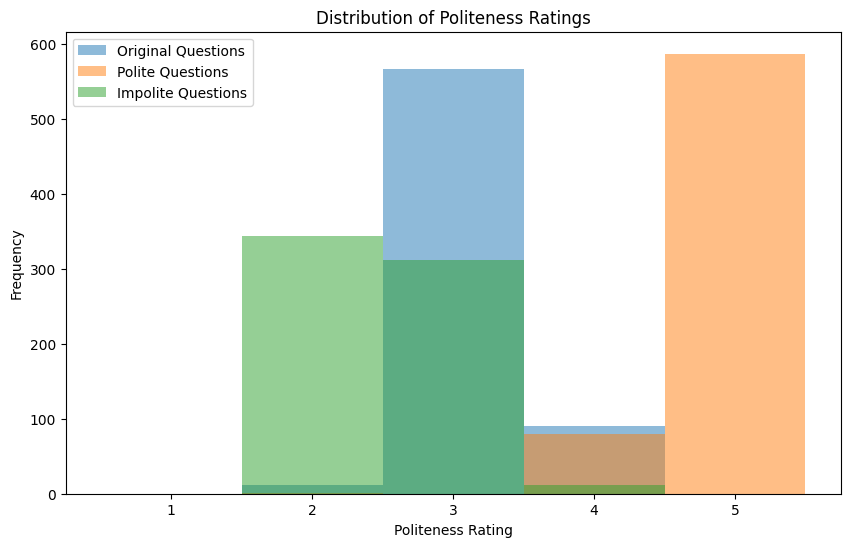

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plotting histograms for each question type
plt.hist(df_results['original_rating'], bins=range(1, 7), alpha=0.5, label='Original Questions', align='left')
plt.hist(df_results['polite_rating'], bins=range(1, 7), alpha=0.5, label='Polite Questions', align='left')
plt.hist(df_results['impolite_rating'], bins=range(1, 7), alpha=0.5, label='Impolite Questions', align='left')

plt.xlabel('Politeness Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Politeness Ratings')
plt.xticks(range(1, 6))
plt.legend()
plt.show()


In [11]:
# Difference between polite and original questions
df_results['polite_diff'] = df_results['polite_rating'] - df_results['original_rating']

# Difference between original and impolite questions
df_results['impolite_diff'] = df_results['original_rating'] - df_results['impolite_rating']

# Average differences
avg_polite_diff = df_results['polite_diff'].mean()
avg_impolite_diff = df_results['impolite_diff'].mean()

print(f"Average increase in politeness rating when using polite phrasing: {avg_polite_diff:.2f}")
print(f"Average decrease in politeness rating when using impolite phrasing: {avg_impolite_diff:.2f}")


Average increase in politeness rating when using polite phrasing: 1.76
Average decrease in politeness rating when using impolite phrasing: 0.62


In [12]:
from scipy.stats import ttest_rel

# Polite vs Original
t_stat_polite, p_value_polite = ttest_rel(df_results['polite_rating'], df_results['original_rating'])
print(f"Polite vs Original: t-statistic = {t_stat_polite:.3f}, p-value = {p_value_polite:.3f}")

# Original vs Impolite
t_stat_impolite, p_value_impolite = ttest_rel(df_results['original_rating'], df_results['impolite_rating'])
print(f"Original vs Impolite: t-statistic = {t_stat_impolite:.3f}, p-value = {p_value_impolite:.3f}")


Polite vs Original: t-statistic = 96.601, p-value = 0.000
Original vs Impolite: t-statistic = 25.060, p-value = 0.000


In [13]:
# Save to CSV
df_results.to_csv('politeness_evaluation_results.csv', index=False)

# Save to Excel
df_results.to_excel('politeness_evaluation_results.xlsx', index=False)
